<a href="https://colab.research.google.com/github/ibwi/ibwi/blob/main/Sequence_tagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP Sequence models and RNN
### Binôme ROUXEL Stéphanie & CHANG Hy-Boui - juillet 2020



# Sequence models and recurrent networks 

## Preliminary remarks

Recurrent networks in *pytorch* expects as input a Tensor in 3 dimensions (*3D tensor*). The axes carry an important semantic: 
- the first axis is "the time" 
- the second one corresponds to the mini-batch
- the third corresponds to the dimension of input vectors (typically the embedding size)


Therefore, a sequence of 5 vectors of 4 features (size 4) is represented as a Tensor of dimensions (5,1,4). If we have 7 sequences of 5 vectors, all of size 4, we get (5,7,4). 

Lets start with some simple code with synthetic data. 

In [ ]:
import pickle # for the real data 
import torch  # Torch + shortcuts
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(1) # To reproduce the experiments

from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import numpy as numpy
import matplotlib.pyplot as plt


In [ ]:
inputs = torch.randn((5,1,4))
print("input sequence :", inputs)
print("The shape : ", inputs.shape)


input sequence : tensor([[[-1.5256, -0.7502, -0.6540, -1.6095]],

        [[ 0.8657,  0.2444, -0.6629,  0.8073]],

        [[ 0.4391,  1.1712,  1.7674, -0.0954]],

        [[ 0.0612, -0.6177, -0.7981, -0.1316]],

        [[-0.7984,  0.3357,  0.2753,  1.7163]]])
The shape :  torch.Size([5, 1, 4])


## A simple recurrent model and  LSTM

A simple recurrent network is for instance of the thpe **nn.RNN**. 
To build it, we must specify: 
- the input size (this implies the size of the Linear Layer that will process input vectors);
- the size of the hidden layer (this implies the size of the Linear Layer that will process the time transition). 

Other options are available and useful, like:
- nonlinearity 
- bias
- batch_first 


The forward function of a recurrent net can handle two types of input and therefore acts in two ways. 

### One step forward
The first one corresponds to one time step: the neural networks reads one input symbol and update the hidden layer. The forward function therefore returns a tuple of two Tensors: the output and the updated hidden layer. 




In [ ]:
recNN = nn.RNN(input_size=4, hidden_size=3)  # Input dim is 4, hidden layer size  is 3

# initialize the hidden state.
h0 = torch.randn(1, 1, 3) # 
print("h0 : ",h0,h0.shape)

# One step 
out, hn = recNN(inputs[0].view(1,1,-1), h0)
print("##################")
print("One step returns: ")
print("  1/  output : ", out, out.shape)
print("  2/  hidden : ", hn, hn.shape)
print("##################")

h0 :  tensor([[[-0.8737, -0.2693, -0.5124]]]) torch.Size([1, 1, 3])
##################
One step returns: 
  1/  output :  tensor([[[-0.6307, -0.0205,  0.0848]]], grad_fn=<StackBackward>) torch.Size([1, 1, 3])
  2/  hidden :  tensor([[[-0.6307, -0.0205,  0.0848]]], grad_fn=<StackBackward>) torch.Size([1, 1, 3])
##################


We can observe that both vectors are the same. Indeed, in a simple recurrent network there is no distinction between the output and the hidden layers.  A prediction can be done by taking into account at each time step this hidden layer: 

$$ h_t = f_1(x_t,h_{t-1})$$
$$ y_t = f_2(h_t)$$

For one step forward, the recurrent net only needs to keep track of the hidden layer. Some more advanced architectures, like **LSTM** use  two kinds of hidden layers: one for the memory managment  named **cell state** (or $c_t$), and the other to make the prediction named  **hidden state** (or $h_t$). The API is generic for all the recurrent nets et returns a tuple at each time step. This tuple gathers the sufficient data to unfold the network. 

### Sequence forward (unfold)
The second "style" of the forward function consists in taking as input a sequence and to unfold the network on this input sequence. It is equivalent to a for loop. 


In [ ]:
# The whole the sequence in one call: unfolding the network 
outputs, hn = recNN(inputs, h0)
print("* outputs:\n",outputs, "\n  shape:",outputs.shape,"\n")
print("* hn:\n",hn, "\n  shape:",hn.shape)

* outputs:
 tensor([[[-0.6307, -0.0205,  0.0848]],

        [[-0.5812,  0.7743,  0.2956]],

        [[-0.2936,  0.9483,  0.1993]],

        [[-0.7406,  0.7238,  0.6722]],

        [[-0.9548,  0.5780,  0.7488]]], grad_fn=<StackBackward>) 
  shape: torch.Size([5, 1, 3]) 

* hn:
 tensor([[[-0.9548,  0.5780,  0.7488]]], grad_fn=<StackBackward>) 
  shape: torch.Size([1, 1, 3])


in this case, the forward function returns: 
- the sequence of the hidden layers associated to each input vector;
- and the last hidden layer. 
The previous code is equivalent to this one: 

In [ ]:
hn=h0 # init 
for t in range(len(inputs)): 
    out, hn = recNN(inputs[t].view(1,1,-1), hn)
    print("at time ",t, " out = ", out)

at time  0  out =  tensor([[[-0.6307, -0.0205,  0.0848]]], grad_fn=<StackBackward>)
at time  1  out =  tensor([[[-0.5812,  0.7743,  0.2956]]], grad_fn=<StackBackward>)
at time  2  out =  tensor([[[-0.2936,  0.9483,  0.1993]]], grad_fn=<StackBackward>)
at time  3  out =  tensor([[[-0.7406,  0.7238,  0.6722]]], grad_fn=<StackBackward>)
at time  4  out =  tensor([[[-0.9548,  0.5780,  0.7488]]], grad_fn=<StackBackward>)


## Usage of LSTM

To illustrate the previous section, the following code replace a simple recurrent network by a LSTM. Look at the differences ! 

In [ ]:
recNN = nn.LSTM(input_size=4, hidden_size=3)  # Input dim is 4, hidden layer size  is 3
h0 =  torch.randn(1, 1, 3) # 
c0 =  torch.randn(1, 1, 3) # 
# One step 

# One step 
out, (hn,cn) = recNN(inputs[0].view(1,1,-1), (h0,c0))
print("##################")
print("One step returns: ")
print("  1/  output : ", out, out.shape)
print("  2/  hidden : ", hn, hn.shape)
print("  3/  cell   : ", cn, cn.shape)
print("##################")


##################
One step returns: 
  1/  output :  tensor([[[0.1313, 0.2055, 0.1265]]], grad_fn=<StackBackward>) torch.Size([1, 1, 3])
  2/  hidden :  tensor([[[0.1313, 0.2055, 0.1265]]], grad_fn=<StackBackward>) torch.Size([1, 1, 3])
  3/  cell   :  tensor([[[0.2867, 0.6155, 1.2126]]], grad_fn=<StackBackward>) torch.Size([1, 1, 3])
##################


It is important to understand these examples and more specifically :
* the parameters "input dimension" and "output dimension" set to 3 ? 
* why we initialize the hidden layer ?
* the *-1* when we call *view* ? 
* ... 
If we unfold the LSTM along the sequence of inputs: 


In [ ]:


out, (hn, cn) = recNN(inputs, (h0,c0))
print("##################")
print("Unfolding the net: ")
print("  1/ out:\n ", out, "\n",out.shape)
print("  2/ hn :\n", hn, "\n",hn.shape )
print("  3/ cn :\n", cn,"\n", cn.shape )
print("##################")

##################
Unfolding the net: 
  1/ out:
  tensor([[[0.1313, 0.2055, 0.1265]],

        [[0.0454, 0.3733, 0.2033]],

        [[0.1518, 0.3830, 0.2379]],

        [[0.0556, 0.2590, 0.1208]],

        [[0.0629, 0.2052, 0.0781]]], grad_fn=<StackBackward>) 
 torch.Size([5, 1, 3])
  2/ hn :
 tensor([[[0.0629, 0.2052, 0.0781]]], grad_fn=<StackBackward>) 
 torch.Size([1, 1, 3])
  3/ cn :
 tensor([[[0.0957, 0.4264, 0.4603]]], grad_fn=<StackBackward>) 
 torch.Size([1, 1, 3])
##################


# Sequence tagging  


The task of *sequence tagging* consists in the attribution of a tag (or a class) to each element  (or words ) of a sequence (a sentence): 
* An observation is a sentence represented as a word sequence;
* A tag sequence is associated to this sentence, one tag per word. 

If the input is sequence of symbols : 
$w_1, \dots, w_M$, with $w_i \in V$, the vocabulary or the finite set of the known words. Assume we have a tagset $T$ le *tagset* which is the set of all possible tags (the output space). At time $i$,  $y_i$ is the tag associated to the word  $w_i$.
The prediction of the model is  $\hat{y}_i$. 
Our goal is to predict the sequence $\hat{y}_1, \dots, \hat{y}_M$, with $\hat{y}_i \in T$.

## A recurrent tagger
We can use a recurrent model to create a sequence tagger. The recurrent network "reads" the sentence and predict the tag sequence. We denote the hidden state of the recurrent network at time $i$ as  $h_i$. The prediction rule is to select   $\hat{y}_i$ as : 

\begin{align}\hat{y}_i = \text{argmax}_j \  (\log \text{Softmax}(Ah_i + b))_j\end{align}

The softmax function gives us a probability distribution over the tagset ($\in T$). The softmax is applied to a linear transformation of the hidden state $h_i$. In the following we can use the logsoftmax associated to the adapted loss. 

## A first (toy) dataset

Let us build our first dataset and define some useful function. 

In [ ]:

# Convert the input sequence into an integer one.
# The mapping is recorded in the dictionnary to_ix
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    tensor = torch.LongTensor(idxs)
    return tensor

# Toy dataset
training_data = [
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]

# The dictionnary : word -> index
word_to_ix = {}
# The other : tag -> index
tag_to_ix = {}
# Build them 
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
    for tag in tags:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)
##
print("Words dict: ", word_to_ix)
print("Tags  dict: ",tag_to_ix)

print("The sentence : ", training_data[0][0])
print("The tag seq. : ", training_data[0][1])
print("#### in the prepared version")
print("The sentence : ", prepare_sequence(training_data[0][0],word_to_ix))
print("The tag seq. : ", prepare_sequence(training_data[0][1],tag_to_ix))

Words dict:  {'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}
Tags  dict:  {'DET': 0, 'NN': 1, 'V': 2}
The sentence :  ['The', 'dog', 'ate', 'the', 'apple']
The tag seq. :  ['DET', 'NN', 'V', 'DET', 'NN']
#### in the prepared version
The sentence :  tensor([0, 1, 2, 3, 4])
The tag seq. :  tensor([0, 1, 2, 0, 1])


In [ ]:
#ajout : calculons les nombres de mots et de tags 
word_vocab_size = len(word_to_ix)
tag_vocab_size = len(tag_to_ix)

print("Unique words: {}".format(len(word_to_ix)))
print("Unique tags: {}".format(len(tag_to_ix)))

Unique words: 9
Unique tags: 3


## Build our first model
Fill the following class. We can use a LSTM our tagger, with 3 components: 
- a LSTM us unfolded on the word sequence to be processed
- an Embedding layer to project words
- A linear layer to feed the log-softmax for prediction purpose. 

These three modules must be created in the constructor of the class. The forward function requires your full attention: 
- the model takes an input sequence: a tensor of word idx
- the embedding layers will generate a new tensor, what is the dimensions ? 
- what is expected by the LSTM module ? 
- what is the dimensions of the LSTM ? 
- what is expected by the final Linear module ? 

Try to write it : 


In [ ]:
class RecurrentTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(RecurrentTagger, self).__init__()
        self.hidden_dim = hidden_dim 

        # on va créer le résultat de mots embedded
        # le premier argument est le nbre de mots ==> donc il s'agit de la taille du vocabulaire
        # le second argument est la dimension de l'encastrement
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # on va définir la fonction LSTM, elle prend les mots embdded en entrée, et renvoie les hidden states en sortie
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # on va aussi définir une couche linéaire qui permet de mapper les couches cachées vers les TAGS
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_dim),
                torch.zeros(1, 1, self.hidden_dim))        
        
    def forward(self, sentence):
      embeds = self.word_embeddings(sentence)
      lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
      tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
      #passage dans la couche linéaire
      tag_scores = F.log_softmax(tag_space, dim=1)
      return tag_scores

# Training 
Now write the code to train this model

In [ ]:
EMBEDDING_DIM = 6
HIDDEN_DIM = 6
accuracy_list = []
loss_list = []

# notre modèle, notre loss et notre optimizer
model = RecurrentTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# on regarde les score avant le training (on met torch.no_grad() pour ne pas entrainer)
# on obtient en sortie (tag_scores) le score pour le tag j du mot i
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)
    #print("tag_scores avant training : ", tag_scores)

for epoch in range(200):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in training_data:
        # Get our inputs ready for the network
        inputs = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        # initialisation de la LOSS et l'ACCURACY
        accuracy = 0.0
        loss=0.0

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance 
        model.zero_grad()

        # Step2: Also, we need to clear out the hidden state of the recurrent net,
        # detaching it from its history on the last instance.
        model.init_hidden()

        # Step 3. Run our forward pass.
        tag_scores = model(inputs)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

        #Step 5. Calcul accuracy 
        accuracy += torch.mean(torch.tensor(targets == tag_scores.argmax(dim=1), dtype=torch.float))

    print(f'\t Epoch: {epoch+1:02} | Loss: {loss:.3f}  | Accuracy: {accuracy*100:.2f}%')
    accuracy_list.append(float(accuracy)) 
    loss_list.append(float(loss))

C:\Users\Hyboui\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


	 Epoch: 01 | Loss: 1.073  | Accuracy: 25.00%
	 Epoch: 02 | Loss: 1.067  | Accuracy: 25.00%
	 Epoch: 03 | Loss: 1.061  | Accuracy: 50.00%
	 Epoch: 04 | Loss: 1.056  | Accuracy: 50.00%
	 Epoch: 05 | Loss: 1.052  | Accuracy: 50.00%
	 Epoch: 06 | Loss: 1.048  | Accuracy: 50.00%
	 Epoch: 07 | Loss: 1.044  | Accuracy: 50.00%
	 Epoch: 08 | Loss: 1.041  | Accuracy: 50.00%
	 Epoch: 09 | Loss: 1.038  | Accuracy: 50.00%
	 Epoch: 10 | Loss: 1.035  | Accuracy: 50.00%
	 Epoch: 11 | Loss: 1.032  | Accuracy: 50.00%
	 Epoch: 12 | Loss: 1.029  | Accuracy: 50.00%
	 Epoch: 13 | Loss: 1.026  | Accuracy: 50.00%
	 Epoch: 14 | Loss: 1.024  | Accuracy: 50.00%
	 Epoch: 15 | Loss: 1.021  | Accuracy: 50.00%
	 Epoch: 16 | Loss: 1.019  | Accuracy: 50.00%
	 Epoch: 17 | Loss: 1.017  | Accuracy: 50.00%
	 Epoch: 18 | Loss: 1.014  | Accuracy: 50.00%
	 Epoch: 19 | Loss: 1.012  | Accuracy: 50.00%
	 Epoch: 20 | Loss: 1.009  | Accuracy: 50.00%
	 Epoch: 21 | Loss: 1.007  | Accuracy: 50.00%
	 Epoch: 22 | Loss: 1.005  | Accur

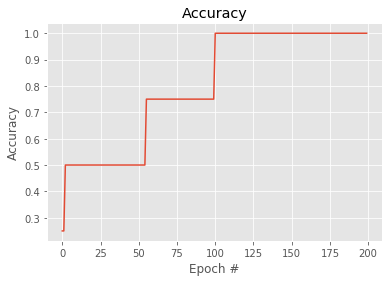

In [ ]:
# Graphiques

plt.style.use("ggplot")
plt.figure()
plt.plot(numpy.arange(0,200),accuracy_list,label="accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.show()

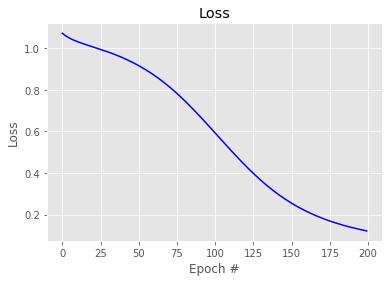

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(numpy.arange(0,200),loss_list,label="loss",c="blue")
plt.title("Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.show()

In [ ]:
# Comparons les résulats à l'attendu 

with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)
    #print("Les tag_scores après training : ", tag_scores)
    #print("La première phrase : ", inputs)
    print("Pour la première phrase, les tags devraient être : ",prepare_sequence(training_data[0][1], tag_to_ix))
    print("les indices max associés aux tags estimés sont :", torch.max(tag_scores, 1).indices) #pour le mot i, les tags_scores sont les maximum
    
    inputs = prepare_sequence(training_data[1][0], word_to_ix)
    tag_scores = model(inputs)
    #print("Les tag_scores après training : ", tag_scores)
    #print("La deuxième phrase : ", inputs)
    print("Pour la deuxième phrase, les tags devraient être: ",prepare_sequence(training_data[1][1], tag_to_ix))
    print("Les indices max associés aux tags estimés sont :", torch.max(tag_scores, 1).indices) #pour le mot i, les tags_scores sont les maximum


# Comme on l'a vu plus haut, pour la première phrase
# Words dict:  {'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}
# Tags  dict:  {'DET': 0, 'NN': 1, 'V': 2}
# The sentence :  tensor([0, 1, 2, 3, 4])
# The tag seq. :  tensor([0, 1, 2, 0, 1]) 
# On retrouve bien [0, 1, 2, 0, 1]) pour les tags estimés

Pour la première phrase, les tags devraient être :  tensor([0, 1, 2, 0, 1])
les indices max associés aux tags estimés sont : tensor([0, 1, 2, 0, 1])
Pour la deuxième phrase, les tags devraient être:  tensor([1, 2, 0, 1])
Les indices max associés aux tags estimés sont : tensor([1, 2, 0, 1])


# A real task
Load the following dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pickle
mydata = pickle.load(open("/content/drive/My Drive/Colab Notebooks/NLP/brown.postag.dataset.p", "rb" ) )
#mydata = pickle.load(open("brown.postag.dataset.p", "rb" ) )

Look at the data, process it as required and then: 
* Spit the dataset in 3 sets:  train / validation / test (80%,10%,10%)
* Learn the model and test it 
* Tune the hyperparameters. What is the best score you can obtain ? 
* Start again with a bi-lstm


In [ ]:
# commençons par regarder un peu les données récupérées

print("Le nombre d'éléments est : ", len(mydata))
print("le type des éléments est : ", type(mydata))
print("voici le premier élément : ", mydata[0])

Le nombre d'éléments est :  57340
le type des éléments est :  <class 'list'>
voici le premier élément :  (['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], ['DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.'])


In [ ]:
# Comme auparavant, on va commencer à créer les dictionnaires pour les mots du vocabulaire
# et aussi pour les tags

#The dictionnary : word -> index

word_to_ix = {}
tag_to_ix = {}

for sent, tags in mydata:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
    for tag in tags:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

            
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    tensor = torch.LongTensor(idxs)
    return tensor


# visualisation des qq données

print("Les mots de la 1ère phrase sont : ", mydata[0][0], "\n")
print("Les tags de la première phase sont : ", mydata[0][1], "\n")

print("Les index associés à la 1ère phrase sont : ", prepare_sequence(mydata[0][0],word_to_ix))
print("Les index associés aux tags de la 1ère phrase sont : ", prepare_sequence(mydata[0][1],tag_to_ix))

print("\n la taille du vocabulaire est : ", len(word_to_ix))
print("\n le nombre de tags est : ", len(tag_to_ix))

Les mots de la 1ère phrase sont :  ['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'] 

Les tags de la première phase sont :  ['DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.'] 

Les index associés à la 1ère phrase sont :  tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24])
Les index associés aux tags de la 1ère phrase sont :  tensor([0, 1, 1, 2, 1, 3, 1, 0, 1, 4, 1, 2, 1, 1, 3, 5, 0, 1, 5, 4, 0, 1, 3, 1,
        5])

 la taille du vocabulaire est :  56057

 le nombre de tags est :  12


### Séparation du dataset

In [ ]:
# le nombre de données est donné par len(mydata), et est égale à 57340
# on va diviser les données d'entrée en 
# 80% training (soit 45872)
# 10% validation (soit 5734)
# 10% test (soir 5734)
#on ne fait pas en random pour garder les phrases entières

trainingSet=mydata[:len(mydata)*80//100]
print(len(trainingSet))

validationSet=mydata[len(mydata)*80//100:len(mydata)*90//100]
print(len(validationSet))

testSet=mydata[len(mydata)*90//100:]
print(len(testSet))


45872
5734
5734


### Training du modèle

In [ ]:
EMBEDDING_DIM = 6 
HIDDEN_DIM = 6
accuracy_list = []
loss_list = []
val_accuracy_list = []
val_loss_list = []

# notre modèle, notre loss et notre optimizer
model = RecurrentTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1) 

# on regarde les score avant le training (on met torch.no_grad() pour ne pas entrainter)
# on obient en sortie (tag_scores) le score pour le tag j du mot i
with torch.no_grad():
    inputs = prepare_sequence(trainingSet[0][0], word_to_ix)
    tag_scores = model(inputs)
    #print("tag_scores avant training : ", tag_scores)

for epoch in range(10):  
    for sentence, tags in trainingSet:
        # Get our inputs ready for the network
        inputs = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        # initialisation de la LOSS et l'ACCURACY
        accuracy = 0.0
        loss=0.0
        val_accuracy=0.0
        val_loss=0.0
  
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance 
        model.zero_grad()

        # Step2: Also, we need to clear out the hidden state of the recurrent net,
        # detaching it from its history on the last instance.
        model.init_hidden()

        # Step 3. Run our forward pass.
        tag_scores = model(inputs)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

        #Step 5. Calcul accuracy      
        accuracy += torch.mean(torch.tensor(targets == tag_scores.argmax(dim=1), dtype=torch.float)) 

#validation set
    with torch.no_grad():
        for sentence, tags in validationSet:
            # Get our inputs ready for the network
            inputs = prepare_sequence(sentence, word_to_ix)
            targets = prepare_sequence(tags, tag_to_ix)

            # initialisation de l'ACCURACY
            val_accuracy = 0.0
            
            # Step 3. Run our forward pass.
            tag_scores = model(inputs)

            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            val_loss = loss_function(tag_scores, targets)
      
            #Step 5. Calcul accuracy      
            val_accuracy += torch.mean(torch.tensor(targets == tag_scores.argmax(dim=1), dtype=torch.float))

    print(f'\t Epoch: {epoch+1:02} | Train Loss: {loss:.3f} | val loss:{val_loss:.3f} | Train Accuracy: {accuracy*100:.2f}% | val Accuracy: {val_accuracy*100:.2f}%')
    accuracy_list.append(float(accuracy))
    val_accuracy_list.append(float(val_accuracy)) 
    loss_list.append(float(loss))
    val_loss_list.append(float(val_loss))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


	 Epoch: 01 | Train Loss: 0.583 | val loss:0.943 | Train Accuracy: 78.95% | val Accuracy: 52.38%
	 Epoch: 02 | Train Loss: 0.375 | val loss:0.893 | Train Accuracy: 89.47% | val Accuracy: 57.14%
	 Epoch: 03 | Train Loss: 0.361 | val loss:0.912 | Train Accuracy: 84.21% | val Accuracy: 57.14%
	 Epoch: 04 | Train Loss: 0.286 | val loss:0.904 | Train Accuracy: 84.21% | val Accuracy: 57.14%
	 Epoch: 05 | Train Loss: 0.248 | val loss:0.915 | Train Accuracy: 89.47% | val Accuracy: 61.90%
	 Epoch: 06 | Train Loss: 0.200 | val loss:1.078 | Train Accuracy: 94.74% | val Accuracy: 71.43%
	 Epoch: 07 | Train Loss: 0.182 | val loss:1.104 | Train Accuracy: 100.00% | val Accuracy: 71.43%
	 Epoch: 08 | Train Loss: 0.182 | val loss:1.177 | Train Accuracy: 94.74% | val Accuracy: 71.43%
	 Epoch: 09 | Train Loss: 0.167 | val loss:1.227 | Train Accuracy: 94.74% | val Accuracy: 71.43%
	 Epoch: 10 | Train Loss: 0.151 | val loss:1.123 | Train Accuracy: 94.74% | val Accuracy: 71.43%


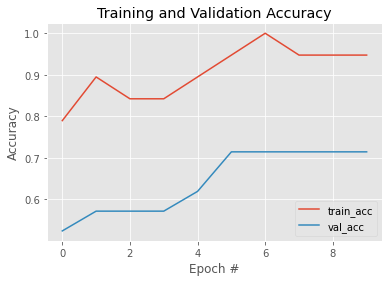

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(numpy.arange(0,10),accuracy_list,label="train_acc")
plt.plot(numpy.arange(0,10),val_accuracy_list,label="val_acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()

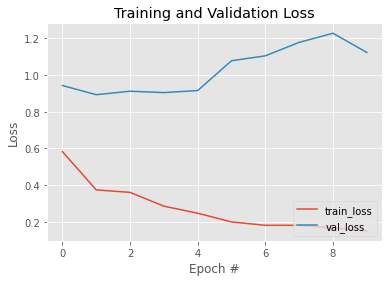

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(numpy.arange(0,10),loss_list,label="train_loss",)
plt.plot(numpy.arange(0,10),val_loss_list,label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower right")
plt.show()

La loss du dataset de validation remonte à partir de 4 epochs. Le modèle semble overfitter.

### Essai d'optimisation du modèle en changeant les hyperparamètres et l'optimizer

In [ ]:
#changement d'optimizer et des dimensions
EMBEDDING_DIM = 12
HIDDEN_DIM = 12
accuracy_list = []
loss_list = []
val_accuracy_list = []
val_loss_list = []

# notre modèle, notre loss et notre optimizer
model = RecurrentTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters()) 

# on regarde les score avant le training (on met torch.no_grad() pour ne pas entrainer)
# on obient en sortie (tag_scores) le score pour le tag j du mot i
with torch.no_grad():
    inputs = prepare_sequence(trainingSet[0][0], word_to_ix)
    tag_scores = model(inputs)
    #print("tag_scores avant training : ", tag_scores)

for epoch in range(10):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in trainingSet:
        # Get our inputs ready for the network
        inputs = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)
        
        # initialisation de la LOSS et l'ACCURACY
        accuracy = 0.0
        loss=0.0
        val_accuracy=0.0
        val_loss=0.0
  
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance 
        model.zero_grad()

        # Step2: Also, we need to clear out the hidden state of the recurrent net,
        # detaching it from its history on the last instance.
        model.init_hidden()

        # Step 3. Run our forward pass.
        tag_scores = model(inputs)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

        #Step 5. Calcul accuracy      
        accuracy += torch.mean(torch.tensor(targets == tag_scores.argmax(dim=1), dtype=torch.float)) 

#validation set
    with torch.no_grad():
        for sentence, tags in validationSet:
            inputs = prepare_sequence(sentence, word_to_ix)
            targets = prepare_sequence(tags, tag_to_ix)
            val_accuracy = 0.0
            tag_scores = model(inputs)
            val_loss = loss_function(tag_scores, targets) 
            val_accuracy += torch.mean(torch.tensor(targets == tag_scores.argmax(dim=1), dtype=torch.float))

    print(f'\t Epoch: {epoch+1:02} | Train Loss: {loss:.3f} | val loss:{val_loss:.3f} | Train Accuracy: {accuracy*100:.2f}% | val Accuracy: {val_accuracy*100:.2f}%')
    accuracy_list.append(float(accuracy))
    val_accuracy_list.append(float(val_accuracy)) 
    loss_list.append(float(loss))
    val_loss_list.append(float(val_loss))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


	 Epoch: 01 | Train Loss: 0.137 | val loss:0.714 | Train Accuracy: 100.00% | val Accuracy: 71.43%
	 Epoch: 02 | Train Loss: 0.101 | val loss:0.673 | Train Accuracy: 100.00% | val Accuracy: 71.43%
	 Epoch: 03 | Train Loss: 0.089 | val loss:0.670 | Train Accuracy: 100.00% | val Accuracy: 76.19%
	 Epoch: 04 | Train Loss: 0.087 | val loss:0.633 | Train Accuracy: 100.00% | val Accuracy: 76.19%
	 Epoch: 05 | Train Loss: 0.094 | val loss:0.611 | Train Accuracy: 94.74% | val Accuracy: 76.19%
	 Epoch: 06 | Train Loss: 0.105 | val loss:0.604 | Train Accuracy: 94.74% | val Accuracy: 80.95%
	 Epoch: 07 | Train Loss: 0.109 | val loss:0.604 | Train Accuracy: 94.74% | val Accuracy: 80.95%
	 Epoch: 08 | Train Loss: 0.109 | val loss:0.599 | Train Accuracy: 94.74% | val Accuracy: 80.95%
	 Epoch: 09 | Train Loss: 0.108 | val loss:0.616 | Train Accuracy: 94.74% | val Accuracy: 80.95%
	 Epoch: 10 | Train Loss: 0.109 | val loss:0.607 | Train Accuracy: 94.74% | val Accuracy: 80.95%


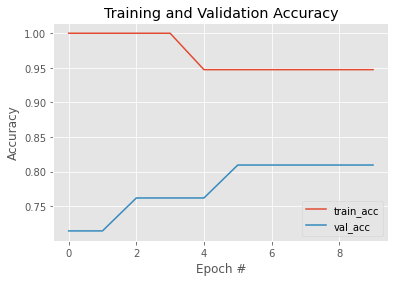

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(numpy.arange(0,10),accuracy_list,label="train_acc")
plt.plot(numpy.arange(0,10),val_accuracy_list,label="val_acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()

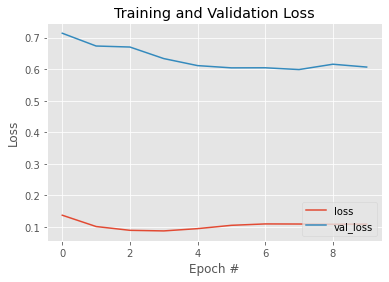

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(numpy.arange(0,10),loss_list,label="loss",)
plt.plot(numpy.arange(0,10),val_loss_list,label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower right")
plt.show()

Le modèle optimisé donne de meilleurs résultats, on conserve ce dernier.
On va vérifier ses résultats sur le jeu de test ci-après.



### Résultat sur le dataset de Test

In [ ]:
#Vérification sur test

for sentence, tags in testSet:
    # Get our inputs ready for the network
    inputs = prepare_sequence(sentence, word_to_ix)
    targets = prepare_sequence(tags, tag_to_ix)

    # initialisation de la LOSS et l'ACCURACY
    test_accuracy = 0.0
    tag_scores = model(inputs)
    test_loss = loss_function(tag_scores, targets)  
    test_accuracy += torch.mean(torch.tensor(targets == tag_scores.argmax(dim=1), dtype=torch.float))

print(f'\t Test Loss: {test_loss:.3f} |Test Accuracy: {test_accuracy*100:.2f}%')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


	 Test Loss: 0.579 |Test Accuracy: 87.50%


Une accuracy de 97,5% sur le test nous semble un bon résultat :-)

# Bi LSTM

### Modèle

In [ ]:
############### ré-import des données

import pickle # for the real data 
import torch  # Torch + shortcuts
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(1) # To reproduce the experiments

from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import numpy as numpy
import matplotlib.pyplot as plt

import pickle
#mydata = pickle.load(open("/content/drive/My Drive/Colab Notebooks/NLP/brown.postag.dataset.p", "rb" ) )
mydata = pickle.load(open("brown.postag.dataset.p", "rb" ) )

word_to_ix = {}
tag_to_ix = {}

for sent, tags in mydata:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
    for tag in tags:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

            
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    tensor = torch.LongTensor(idxs)
    return tensor



trainingSet=mydata[:len(mydata)*80//100]
print(len(trainingSet))

validationSet=mydata[len(mydata)*80//100:len(mydata)*90//100]
print(len(validationSet))

testSet=mydata[len(mydata)*90//100:]
print(len(testSet))

45872
5734
5734


In [ ]:
class BiLSTM(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,bidirectional=True) # on ajoute un paramètre bidirectional = True
        self.hidden2tag = nn.Linear(hidden_dim * 2, tagset_size) # on double le nombre de hidden layers

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_dim*2), #on double les hidden layers
                torch.zeros(1, 1, self.hidden_dim*2))        
        
    def forward(self, sentence):
      embeds = self.word_embeddings(sentence)
      lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
      tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
      #passage dans la couche linéaire
      tag_scores = F.log_softmax(tag_space, dim=1)
      return tag_scores

### Training 1 sur le modèle Bi-LSTM

In [ ]:
# On entraine sur le modèle bilstm ==> A LANCER

EMBEDDING_DIM = 6 
HIDDEN_DIM = 6
accuracy_list = []
loss_list = []
val_accuracy_list = []
val_loss_list = []

# notre modèle, notre loss et notre optimizer
model = BiLSTM(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1) 


# on regarde les score avant le training (on met torch.no_grad() pour ne pas entrainter)
# on obient en sortie (tag_scores) le score pour le tag j du mot i
with torch.no_grad():
    inputs = prepare_sequence(trainingSet[0][0], word_to_ix)
    tag_scores = model(inputs)
    #print("tag_scores avant training : ", tag_scores)

for epoch in range(10):  
    for sentence, tags in trainingSet:
        # Get our inputs ready for the network
        inputs = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        # initialisation de la LOSS et l'ACCURACY
        accuracy = 0.0
        loss=0.0
        val_accuracy=0.0
        val_loss=0.0

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance 
        model.zero_grad()

        # Step2: Also, we need to clear out the hidden state of the recurrent net,
        # detaching it from its history on the last instance.
        model.init_hidden()

        # Step 3. Run our forward pass.
        tag_scores = model(inputs)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

        #Step 5. Calcul accuracy     
        accuracy += torch.mean(torch.tensor(targets == tag_scores.argmax(dim=1), dtype=torch.float))


    #validation set
    with torch.no_grad():
        for sentence, tags in validationSet:
            inputs = prepare_sequence(sentence, word_to_ix)
            targets = prepare_sequence(tags, tag_to_ix)
            val_accuracy = 0.0
            tag_scores = model(inputs)
            val_loss = loss_function(tag_scores, targets) 
            val_accuracy += torch.mean(torch.tensor(targets == tag_scores.argmax(dim=1), dtype=torch.float))

    print(f'\t Epoch: {epoch+1:02} | Train Loss: {loss:.3f} | val loss:{val_loss:.3f} | Train Accuracy: {accuracy*100:.2f}% | val Accuracy: {val_accuracy*100:.2f}%')
    accuracy_list.append(float(accuracy))
    val_accuracy_list.append(float(val_accuracy)) 
    loss_list.append(float(loss))
    val_loss_list.append(float(val_loss))

C:\Users\Hyboui\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Hyboui\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


	 Epoch: 01 | Train Loss: 0.300 | val loss:0.984 | Train Accuracy: 94.74% | val Accuracy: 71.43%
	 Epoch: 02 | Train Loss: 0.194 | val loss:1.069 | Train Accuracy: 100.00% | val Accuracy: 71.43%
	 Epoch: 03 | Train Loss: 0.154 | val loss:1.083 | Train Accuracy: 100.00% | val Accuracy: 71.43%
	 Epoch: 04 | Train Loss: 0.132 | val loss:1.036 | Train Accuracy: 94.74% | val Accuracy: 71.43%
	 Epoch: 05 | Train Loss: 0.117 | val loss:1.060 | Train Accuracy: 100.00% | val Accuracy: 71.43%
	 Epoch: 06 | Train Loss: 0.097 | val loss:1.054 | Train Accuracy: 100.00% | val Accuracy: 71.43%
	 Epoch: 07 | Train Loss: 0.093 | val loss:1.024 | Train Accuracy: 100.00% | val Accuracy: 71.43%
	 Epoch: 08 | Train Loss: 0.082 | val loss:1.024 | Train Accuracy: 100.00% | val Accuracy: 71.43%
	 Epoch: 09 | Train Loss: 0.078 | val loss:1.030 | Train Accuracy: 100.00% | val Accuracy: 71.43%
	 Epoch: 10 | Train Loss: 0.074 | val loss:1.033 | Train Accuracy: 100.00% | val Accuracy: 76.19%


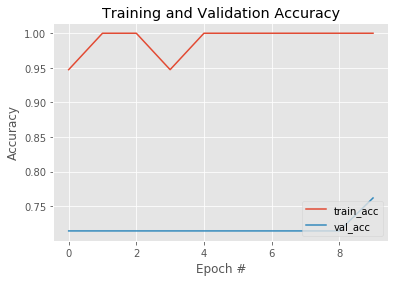

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(numpy.arange(0,10),accuracy_list,label="train_acc")
plt.plot(numpy.arange(0,10),val_accuracy_list,label="val_acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()

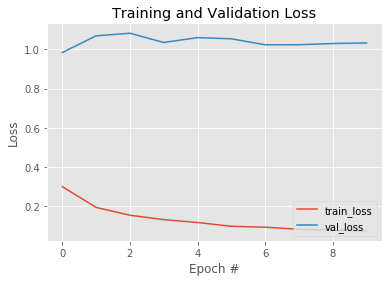

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(numpy.arange(0,10),loss_list,label="train_loss",)
plt.plot(numpy.arange(0,10),val_loss_list,label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower right")
plt.show()

In [ ]:
#Vérification sur test

for sentence, tags in testSet:
    # Get our inputs ready for the network
    inputs = prepare_sequence(sentence, word_to_ix)
    targets = prepare_sequence(tags, tag_to_ix)

    # initialisation de la LOSS et l'ACCURACY
    test_accuracy = 0.0
    tag_scores = model(inputs)
    test_loss = loss_function(tag_scores, targets)  
    test_accuracy += torch.mean(torch.tensor(targets == tag_scores.argmax(dim=1), dtype=torch.float))

print(f'\t Test Loss: {test_loss:.3f} |Test Accuracy: {test_accuracy*100:.2f}%')

C:\Users\Hyboui\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


	 Test Loss: 0.488 |Test Accuracy: 87.50%


### Training 2 sur le modèle Bi-LSTM optimisé

In [ ]:
# On entraine sur le modèle optimisé en bilstm
# on reset au préalable les données, le modèle, etc.

EMBEDDING_DIM = 12
HIDDEN_DIM = 12
accuracy_list = []
loss_list = []
val_accuracy_list = []
val_loss_list = []

# notre modèle, notre loss et notre optimizer
model = BiLSTM(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# on regarde les score avant le training (on met torch.no_grad() pour ne pas entrainter)
# on obient en sortie (tag_scores) le score pour le tag j du mot i
with torch.no_grad():
    inputs = prepare_sequence(trainingSet[0][0], word_to_ix)
    tag_scores = model(inputs)
    #print("tag_scores avant training : ", tag_scores)

for epoch in range(10):  
    for sentence, tags in trainingSet:
        # Get our inputs ready for the network
        inputs = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        # initialisation de la LOSS et l'ACCURACY
        accuracy = 0.0
        loss=0.0
        val_accuracy=0.0
        val_loss=0.0

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance 
        model.zero_grad()

        # Step2: Also, we need to clear out the hidden state of the recurrent net,
        # detaching it from its history on the last instance.
        model.init_hidden()

        # Step 3. Run our forward pass.
        tag_scores = model(inputs)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

        #Step 5. Calcul accuracy     
        accuracy += torch.mean(torch.tensor(targets == tag_scores.argmax(dim=1), dtype=torch.float))


    #validation set
    with torch.no_grad():
        for sentence, tags in validationSet:
            inputs = prepare_sequence(sentence, word_to_ix)
            targets = prepare_sequence(tags, tag_to_ix)
            val_accuracy = 0.0
            tag_scores = model(inputs)
            val_loss = loss_function(tag_scores, targets) 
            val_accuracy += torch.mean(torch.tensor(targets == tag_scores.argmax(dim=1), dtype=torch.float))

    print(f'\t Epoch: {epoch+1:02} | Train Loss: {loss:.3f} | val loss:{val_loss:.3f} | Train Accuracy: {accuracy*100:.2f}% | val Accuracy: {val_accuracy*100:.2f}%')
    accuracy_list.append(float(accuracy))
    val_accuracy_list.append(float(val_accuracy)) 
    loss_list.append(float(loss))
    val_loss_list.append(float(val_loss))

C:\Users\Hyboui\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Hyboui\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


	 Epoch: 01 | Train Loss: 0.876 | val loss:1.175 | Train Accuracy: 68.42% | val Accuracy: 71.43%
	 Epoch: 02 | Train Loss: 0.812 | val loss:0.847 | Train Accuracy: 78.95% | val Accuracy: 66.67%
	 Epoch: 03 | Train Loss: 0.497 | val loss:0.879 | Train Accuracy: 68.42% | val Accuracy: 71.43%
	 Epoch: 04 | Train Loss: 0.591 | val loss:0.596 | Train Accuracy: 78.95% | val Accuracy: 76.19%
	 Epoch: 05 | Train Loss: 0.644 | val loss:0.689 | Train Accuracy: 68.42% | val Accuracy: 76.19%
	 Epoch: 06 | Train Loss: 0.599 | val loss:0.728 | Train Accuracy: 73.68% | val Accuracy: 66.67%
	 Epoch: 07 | Train Loss: 0.468 | val loss:0.787 | Train Accuracy: 78.95% | val Accuracy: 66.67%
	 Epoch: 08 | Train Loss: 0.380 | val loss:0.848 | Train Accuracy: 84.21% | val Accuracy: 71.43%
	 Epoch: 09 | Train Loss: 0.474 | val loss:0.821 | Train Accuracy: 84.21% | val Accuracy: 66.67%
	 Epoch: 10 | Train Loss: 0.477 | val loss:0.828 | Train Accuracy: 84.21% | val Accuracy: 76.19%


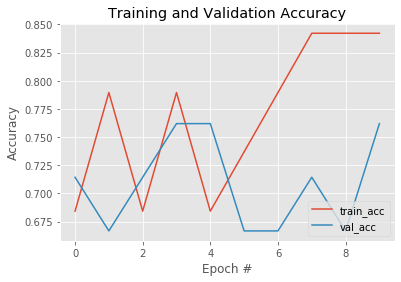

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(numpy.arange(0,10),accuracy_list,label="train_acc")
plt.plot(numpy.arange(0,10),val_accuracy_list,label="val_acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()

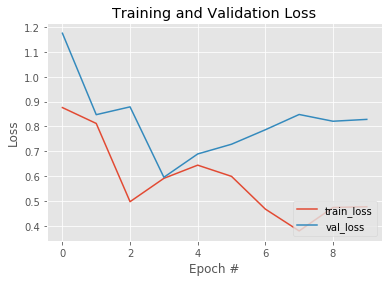

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(numpy.arange(0,10),loss_list,label="train_loss",)
plt.plot(numpy.arange(0,10),val_loss_list,label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower right")
plt.show()

In [ ]:
#Vérification sur test

for sentence, tags in testSet:
    # Get our inputs ready for the network
    inputs = prepare_sequence(sentence, word_to_ix)
    targets = prepare_sequence(tags, tag_to_ix)

    # initialisation de la LOSS et l'ACCURACY
    test_accuracy = 0.0
    tag_scores = model(inputs)
    test_loss = loss_function(tag_scores, targets)  
    test_accuracy += torch.mean(torch.tensor(targets == tag_scores.argmax(dim=1), dtype=torch.float))

print(f'\t Test Loss: {test_loss:.3f} |Test Accuracy: {test_accuracy*100:.2f}%')

C:\Users\Hyboui\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


	 Test Loss: 0.700 |Test Accuracy: 79.17%


## Conclusion

Avec le modèle LSTM optimisé, on obtient de très bons résultats (Test Loss: 0.579 |Test Accuracy: 87.50%).
Nous avons développé un modèle supplémentaire qui est le bi-lstm, mais malheureusement, nous n'obtenons pas de meilleurs résultats :
- bi-lstm : Test Loss: 0.488 |Test Accuracy: 87.50%, 
- bi-lstm optimisé Test Loss: 0.700 |Test Accuracy: 79.17%

Pour notre sujet, il vaut donc mieux utilisé le modèle LSTM optimisé avec un accuracy de 87.50%.

